### Content
- [Import Libraries](#Import-Libraries)
- [Functions for Basic Model](#Functions-for-Basic-Model)
- [Functions for Basic Similarity Metrics](#Functions-for-Basic-Similarity-Metrics)
- [Functions for Titles-Based Collaborative Filtering](#Functions-for-Titles-Based-Collaborative-Filtering)
- [Other Functions](#Other-Functions)
- [Import Data](#Import-Data)
- [Train Test Split Dataset](#Train-Test-Split-Dataset)
- [Metrics](#Metrics)
- [Null Model](#Null-Model)
- [Recommendation for Users With Zero History - Basic Model](#Recommendation-for-Users-With-Zero-History---Basic-Model)
- [Basic Similarity Metric Model](#Basic-Similarity-Metric-Model)
- [Item-Based Collaborative Filtering](#Item-Based-Collaborative-Filtering)
- [Comparing and Evaluating the BSM and CFSM](#Comparing-and-Evaluating-the-BSM-and-CFSM)
- [Conclusion](#Conclusion)

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse
import scipy.stats as stats

import math
import time

from sklearn.model_selection import train_test_split

### Functions for Basic Model

In [2]:
def make_basic_recommendations(basic_ranking, username, data):
    # Load the basic_ranking file and return the list without the manga dropped by user
    if username in data['member'].unique():
        index_read = data[data['member'] == username]['index']
        
        # Drop the title read
        basic_ranking = basic_ranking.drop(index=index_read)
        
        # Rank the titles
        basic_ranking['ranking'] = np.arange(basic_ranking.shape[0])
        
        #Return result
        return basic_ranking 
    else:
        # Rank the titles
        basic_ranking['ranking'] = np.arange(basic_ranking.shape[0])
        
        # Return result
        return basic_ranking 

### Functions for Basic Similarity Metrics

In [306]:
def calculate_basic_similarity_matrix(data, savepath):
    # get genres, themes and demographic col
    genres_themes_demographic_col = [col for col in data.columns if ('themes' in col) or ('genres' in col) or ('demographic' in col)]

    # Get DataFrame With genres_themes_col and manga title index
    bsm_raw_data = data[genres_themes_demographic_col + ['manga_length', 'clusters', 'index']].groupby('index').sum()

    # Calculate the similarity matrix using themes
    bsm = pd.DataFrame(cosine_similarity(bsm_raw_data), index = bsm_raw_data.index, columns=bsm_raw_data.index)
    
    # Save bsm to csv
    bsm.to_csv(savepath)
    
    # Return bsm
    return bsm

def bsm_recommendation(manga_read_list, basic_similarity_matrix):
    
    # Assign manga_read_list to index_read
    index_read = manga_read_list
    
    # Get up a dictionary for the results
    results = {}
    
    # Get the score for each read title
    for title in index_read:
        results[title] = basic_similarity_matrix[title]

    # Change into dataframe
    results_df = pd.DataFrame.from_dict(results)

    # Sum the scores by titles
    results_df['bsm_score'] = results_df.sum(axis=1)

    # Sort by the bsm_score
    results_df.sort_values('bsm_score', ascending=False, inplace=True)
    
    # Drop titles read
    #results_df = results_df.drop(index=index_read)
    
    # Rank the titles
    results_df['ranking'] = np.arange(results_df.shape[0])
    
    # Return results
    return results_df[['bsm_score', 'ranking']]

### Functions for Titles-Based Collaborative Filtering

In [307]:
def centering_to_mean(data):
    return (data.T - data.mean(axis=1)).T

###########################################################################################################################

def calculate_titles_based_similarity_matrix(manga, savepath):
    # Centre each user scores
    manga_mc = centering_to_mean(manga.T)

    # Fill missing values as 0 as user has not read the title yet
    sparse_manga_mc = sparse.csr_matrix(manga_mc.fillna(0))

    # Calculate the cosine similarity matrix between the titles and input into a dataframe
    manga_similarity = cosine_similarity(sparse_manga_mc)
    manga_similarity = pd.DataFrame(manga_similarity, index=manga_mc.index, columns=manga_mc.index)
    manga_similarity.to_csv(savepath)
    
    # Return the manga_similarity
    return manga_similarity
    
###########################################################################################################################

def cal_user_rating(similarity_matrix, title_index, user_score_all_movies, threshold):
    # Get the similarity matrix coefficients for the title with other movies
    title_similarity_coefficients = similarity_matrix[title_index].drop(title_index)
    #print(title_similarity_coefficients.shape)
    
    # Extract only the values above the threshold
    title_similarity_coefficients = title_similarity_coefficients[title_similarity_coefficients > threshold]
    #print(title_similarity_coefficients.shape)
    
    # Calculate the titles weights
    title_weights = title_similarity_coefficients/title_similarity_coefficients.sum()
    #print(title_weights.shape)
    
    # Fill all NA with 0
    user_score_all_movies = user_score_all_movies.loc[title_similarity_coefficients.index].fillna(0)
    #print(user_score_all_movies.shape)
    
    # Return the calculated score for this movie and user
    return np.dot(title_weights, user_score_all_movies)

###########################################################################################################################

def calculate_titles_based_cf_scores(manga, manga_similarity, usernames = None, threshold=0):
    
    # Create empty dictionary for storing usernames and scores for each title
    recommender = {}
    
    # Set the manga_T and members key depending on the type of input from usernames
    if usernames == None:
        # Set dataset for calculating scores with similarity matrix
        manga_T = manga.T
        # Store users_name in the recommender dictionaary
        recommender['members'] = manga.index

    elif (type(usernames) == str) or type(usernames) == list:
        # Set dataset for calculating scores with similarity matrix
        manga_T = manga.T[usernames]
        # Store user_name in the recommender dictionaary
        recommender['members'] = usernames

    else:
        print("'usernames' is not of type 'str', 'list' or 'NoneType'")
        return(None)

    # Start the prediction calculations
    count = 1
    for title in manga.columns:
        recommender[title] = cal_user_rating(manga_similarity, title, manga_T, threshold)
        print(f"Completion:\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t", end='\r')
        print(f"Completion: {round(count/len(manga.columns)*100, 5)}%", end='\r')
        count+=1

    # Store predicted ratings in dataframe
    recommender_df = pd.DataFrame.from_dict(recommender, orient='index').T.set_index('members')
    
    #  Save to csv in row format
    for user in recommender_df.index:
        recommender_df.loc[[user]].to_csv(f'../data_titles_based_cf_user_scores/{user}.csv')

###########################################################################################################################

def cf_recommend_manga_to_user(username):
    # Read the predicted scores for username, drop username
    recommender_df = pd.read_csv(f'../data_titles_based_cf_user_scores/{username}.csv', )
    recommender_df = recommender_df.drop(columns='members')
    
    # Change the columns of titles from string to integer
    recommender_df.rename(columns = {i: int(i) for i in recommender_df.columns}, inplace=True)
  
    # Transpose and Sort by the scores
    recommender_df = recommender_df.T.sort_values(0, ascending=False)
    recommender_df.rename(columns={0:'title_cf_score'}, inplace=True)
    
    # Select Only titles with positive scores
    recommender_df = recommender_df[recommender_df['title_cf_score']>0]
    
    # generate Ranking
    recommender_df['ranking'] = np.arange(recommender_df.shape[0])
    
    # Return results
    return recommender_df

### Other Functions

In [454]:
def recommendation_evaluation(recommended_set, read_set):
    
    # Change both recommended set and read set to set
    recommended_set = set(recommended_set)
    read_set = set(read_set)
    
    match_length = len(read_set.intersection(recommended_set))
    if match_length:
        return [True, len(read_set), match_length]
    else:
        return [False, len(read_set), match_length]
    
    
def evaluate_and_compile(train_dataset, evaluation_dataset, top_k, recommendation_model_no, 
                         similiarity_matrix=None, drop_train_title_in_recommendation=True):
    # Empty dict for storing results
    evaluation_result = {}
    
    # Counter to track progress
    count = 0
    
    # Get member list
    member_list = evaluation_dataset['member'].unique()
    
    # Loop to evaluate each member recommendation and get the metrics
    for user in member_list:
        # Get the read list of the member
        test_read_list = evaluation_dataset[evaluation_dataset['member']==user]['index'].values
        train_read_list = train_dataset[train_dataset['member']==user]['index'].values
        
        # Get the recommendation_list from the models depending on the model_no
        if recommendation_model_no == 1:
            # Basic Recommendation
            recommendation_list = bsm_recommendation(train_read_list, similiarity_matrix).index
        elif recommendation_model_no == 2:
            # Item-Based Collaborative Filtering
            recommendation_list = cf_recommend_manga_to_user(user).index
        
        # Store the result of the evaluation into the evaluation_result dict
        if drop_train_title_in_recommendation:
            # Create recommendation list with titles not in the train data set
            new_recommendation_list = [title for title in recommendation_list if title not in train_read_list]
            # Assign new recommendation list to recommendation list
            recommendation_list = new_recommendation_list
        
        evaluation_result[user] = recommendation_evaluation(recommendation_list[0:top_k], test_read_list)
        
        # Add 1 to counter
        count+=1
        
        # Print the complete percentage
        if not count%10:
            print("\t"*60, end='\r')
            print(f"Assessing recommendations. Progress: {count/member_list.shape[0]*100}%", end='\r')
    
    # Print Complete
    print()
    #print("\t"*30, end='\r')
    print("Complete!!")
    
    # Store the evaluation_result into a DataFrame
    result=pd.DataFrame.from_dict(evaluation_result, orient='index', columns=['result', 'no_titles_read', 'no_match'])
    
    # Calculate the precision at k
    result['precision@k']=result['no_match']/top_k
    
    # Return result
    return result

def calculate_accuracy_by_manga_numbers_read(results):
    # Calculate the accuracy of the recommendation based on number of mangas read
    
    # Group by number of titles read and the results (True and False)
    results_summary = results.groupby(['no_titles_read', 'result'])['no_match'].count().reset_index()
    
    # Pivot by the result so that True and False are side by side for calculation
    results_summary = results_summary.pivot(index ='no_titles_read', columns='result').reset_index()
    
    # Fill all NA as 0
    results_summary.fillna(0, inplace=True)
    
    # Calculate the number of members by adding Number of True and False together
    results_summary['total_members'] = results_summary['no_match'][True] + results_summary['no_match'][False]
    
    # Calculate the accuracy for each group based on number of titles read
    results_summary['accuracy'] = results_summary['no_match'][True]/results_summary['total_members']
    
    # Return results_summary
    return results_summary


def plot_accuracy(data):
    # Plot the accuracy of recommendation and number of member by the number of titles read
    fig, ax = plt.subplots(2,1, figsize=[10,8], sharex=True)
    fig.tight_layout(rect=(0,0,1,0.95))
    # Plot Accuracy vs Number of Titles Read
    sns.lineplot(x='no_titles_read', y='accuracy', data=data, marker = 'o', ax=ax[0])
    ax[0].set_xlabel('No of Titles Read')
    ax[0].set_ylabel("Accuracy")

    # Plot No of Members vs Number of Titles Read
    sns.lineplot(x='no_titles_read', y='total_members', data=data, marker = 'o', ax=ax[1])
    ax[1].set_xlabel('No of Titles Read')
    ax[1].set_ylabel("Number of Members")

    # Set the figure TItle
    plt.suptitle("Average Accuracy of Recommendations Vs No of Titles Member Read", fontweight='bold', fontsize=15)

### Import Data

In [6]:
data = pd.read_csv('../data_cleaned/data_merged.csv', keep_default_na=False, na_values=['-', '', ' '])
manga_titles = pd.read_csv('../data_cleaned/manga_titles_cleaned.csv')
manga_titles.set_index('index', inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (3,4,9,89) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [7]:
data['manga_length'] = data['manga_length'].astype(str)
data['clusters'] = data['clusters'].astype(str)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1434060 entries, 0 to 1434059
Data columns (total 100 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   index                      1434060 non-null  int64  
 1   manga_title                1434060 non-null  object 
 2   manga_link                 1434060 non-null  object 
 3   volumes                    1434060 non-null  object 
 4   chapters                   1434060 non-null  object 
 5   publication_status         1434060 non-null  object 
 6   published                  1434060 non-null  object 
 7   serialization              1434060 non-null  object 
 8   authors                    1434060 non-null  object 
 9   published_year_start       1434060 non-null  object 
 10  genres_Adventure           1434060 non-null  float64
 11  genres_Action              1434060 non-null  float64
 12  genres_Horror              1434060 non-null  float64
 13  genres_Dram

### Train Test Split Dataset

In [9]:
# Set the number of titles each member read
temp = data.groupby('member')['manga_title'].count()

# Filter away those member who read less than 50 books
X = data[data['member'].isin(temp[temp>=34].index)]
X_remain = data[data['member'].isin(temp[temp<34].index)]

# Split the dataset into train and test
data_train, data_test = train_test_split(X, stratify=X['member'], train_size=0.7, random_state=42)

# Adding X_remain back to X
data_train = pd.concat((data_train, X_remain))

In [10]:
# Shape of X_train
data_train.shape

(1362482, 100)

In [11]:
# Shape of X_test
data_test.shape

(71578, 100)

In [12]:
# % of dataset used for testing
data_test.shape[0]/data_train.shape[0]

0.05253500596705131

In [13]:
# Creating a pivot table
manga = pd.pivot_table(data=data_train, index='member', columns='index', values='score', aggfunc='mean')
manga

index,0,1,2,3,4,5,6,7,8,9,...,10390,10391,10392,10393,10394,10395,10396,10397,10398,10399
member,,,,,,,,,,,,,,,,,,,,,
-------,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
------------FROG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
----2o,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
----Brian----,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
----KIWI----,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zzzzztttt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zzzzzura,NaN,NaN,NaN,NaN,9.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zzzzzz1234124512,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# Number of readers for each manga
manga.shape[0] - manga.isnull().sum()

index
0        1959
1        2452
2        2365
3        1460
4        1484
         ... 
10395     119
10396      69
10397      84
10398     440
10399     467
Length: 2137, dtype: int64

### Metrics
The metrics which we will be using to judge if the model is effective is if the reader reads at least 1 title in the recommended list of 10 titles.

### Null Model
In total there are 2137 titles and the null model for each reader is different as they would have read different amount of titles. As such, to find the null model for each reader, we will use the hypergeometric distribution to calculate the probability of at least 1 title that the reader is interested in his/her first 10 selections for both the train and test data set. The average mean from all the member for the train data set is 0.015584 while the average mean for test data set is 0.082798.

In [15]:
# Number of titles
data['index'].nunique()

2137

#### Null model for train data set

In [476]:
# To get the number of titles each reader have not read
titles_unread = pd.DataFrame(data_train['member'].unique(), columns=['member'])
titles_unread['no_of_titles_unread'] = data['index'].nunique()

# To get the number of titles each reader is interested in
titles_interested = data_train.groupby('member')['index'].count().sort_values(ascending=False).reset_index()
titles_interested.columns = ['member', 'no_of_titles_interested']

# To merge the titles_unread and titles_read together
null_model_calculations = titles_interested.merge(titles_unread, on = 'member')
null_model_calculations.set_index('member', inplace=True)

# Calculate the null model for each reader/member
null_model_results = {}
for member in null_model_calculations.index:
    # Generating the distribution for each member
    hypergeom_distrn = stats.hypergeom(null_model_calculations.loc[member, 'no_of_titles_unread'], null_model_calculations.loc[member, 'no_of_titles_interested'], 10)
    x = np.arange(0, 11)
    pmf_interested = hypergeom_distrn.pmf(x)
    # Calculate the null_model for each member/reader by using 1 - sum(prob at least 1 interested title in 10 selection)
    null_model_results[member] = pmf_interested[1:].sum()
    
# Probability of member finding interested titles at first 10 selections
null_model_results_df = pd.DataFrame.from_dict(null_model_results, orient='index', columns=['prob_found_titles'])
null_model_results_df.mean()

prob_found_titles    0.015584
dtype: float64

#### Null model for test data set

In [32]:
# To get the number of titles each reader have not read
titles_unread = (data_train['index'].nunique() - data_train.groupby('member')['index'].count().sort_values(ascending=False)).reset_index()
titles_unread.columns = ['member', 'no_of_titles_unread']

# To get the number of titles each reader is interested in
titles_interested = data_test.groupby('member')['index'].count().sort_values(ascending=False).reset_index()
titles_interested.columns = ['member', 'no_of_titles_interested']

# To merge the titles_unread and titles_read together
null_model_calculations = titles_interested.merge(titles_unread, on = 'member')
null_model_calculations.set_index('member', inplace=True)

# Calculate the null model for each reader/member
null_model_results = {}
for member in null_model_calculations.index:
    # Generating the distribution for each member
    hypergeom_distrn = stats.hypergeom(null_model_calculations.loc[member, 'no_of_titles_unread'], null_model_calculations.loc[member, 'no_of_titles_interested'], 10)
    x = np.arange(0, 11)
    pmf_interested = hypergeom_distrn.pmf(x)
    # Calculate the null_model for each member/reader by using 1 - sum(prob at least 1 interested title in 10 selection)
    null_model_results[member] = pmf_interested[1:].sum()
    
# Probability of member finding interested titles at first 10 selections
null_model_results_df = pd.DataFrame.from_dict(null_model_results, orient='index', columns=['prob_found_titles'])
null_model_results_df.mean()

prob_found_titles    0.082798
dtype: float64

### Recommendation for Users With Zero History - Basic Model

Users with 1 title read but read_status is indicated as 'dropped' will be considered as users with zero history as that meant that the user did not like the title and it would not be good for the system to recommend a title based on that negative history. As such, to recommend titles from highest average score to lowest (skipping titles which user have read).

In [700]:
# To create title and average score file sorted from highest to lowest
basic_ranking = data_train.groupby(['index'])[['title_avg_score']].mean().sort_values('title_avg_score', ascending=False)
basic_ranking.to_csv('../data_production/basic_ranking.csv')

In [701]:
username = '---Adina---'
make_basic_recommendations(basic_ranking, username, data_train)

,title_avg_score,ranking
index,,
0,9.638804,0
1,9.474453,1
2,9.453177,2
3,9.332879,3
10,9.297191,4
...,...,...
4019,6.130256,2131
10351,5.988372,2132
10337,5.957143,2133


### Basic Similarity Metric Model

As recommendation using basic similarity metric are dependent on the features used for comparing against each title. As such features such as genres, themes, demographic and manga_length can be considered in creating the similarity metric.
This model will be used for recommending users who has read 1 to 5 titles where the read_status are 'On-Hold' or 'Completed'.

In [54]:
# Calculate basic similiarity metrics
bsm = calculate_basic_similarity_matrix(data_train, "../data_production/title_bsm.csv")

# Test Recommendation system
username='----Brian----'
bsm_recommendation(data[data['member']==username]['index'], bsm)

,bsm_score,ranking
index,,
175,3.942845,0
256,3.864203,1
3192,3.859056,2
7079,3.841890,3
262,3.841890,4
...,...,...
3782,0.000000,2132
307,0.000000,2133
446,0.000000,2134


#### Evaluate accuracy using train data set

In [465]:
# Evaluate using train data set using the first 10000 members
train_bsm_result = evaluate_and_compile(data_train, data_train[data_train['member'].isin(data_train['member'].unique()[0:10000])], 
                                        10, 1, bsm, drop_train_title_in_recommendation=False)

# Average of the 4 parameters
train_bsm_result.mean()

Assessing recommendations. Progress: 100.0%																	
Complete!!


result             0.82350
no_titles_read    19.03970
no_match           1.39370
precision@k        0.13937
dtype: float64

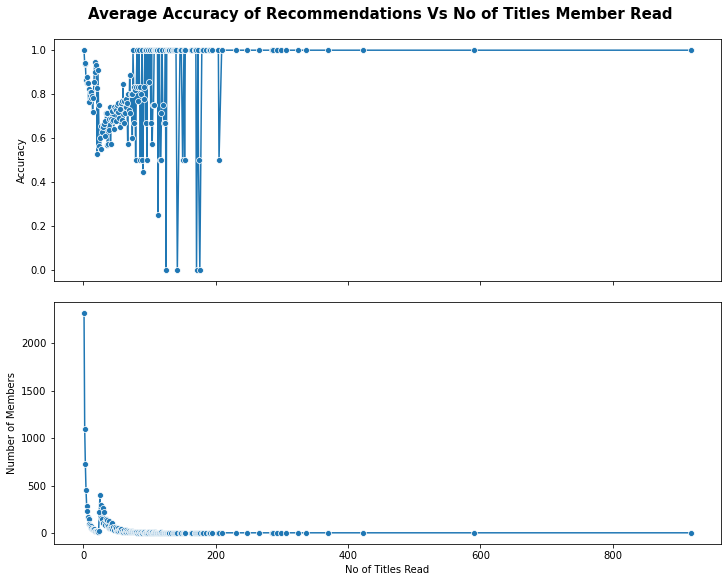

In [466]:
# Calculate the accuracy of the recommendation based on number of mangas read
train_bsm_results_summary = calculate_accuracy_by_manga_numbers_read(train_bsm_result)
plot_accuracy(train_bsm_results_summary)

In [467]:
# Apply grouping based on number of titles read
result = train_bsm_result
result['groupings'] = result['no_titles_read'].apply(lambda x: 'heavy_readers' if x > 50 else 'moderate_reader' if x > 30 else 'light_reader')

# Calculate the mean Accuracy of Each Groups
result.groupby('groupings')['result'].agg(['mean', 'count'])

,mean,count
groupings,,
heavy_readers,0.759640,778
light_reader,0.864972,7591
moderate_reader,0.660944,1631


#### Evaluate accuracy using test data set

In [468]:
# Evaluate using test data set
test_bsm_result = evaluate_and_compile(data_train, data_test, 10, 1, bsm)

# Average of the 4 parameters
test_bsm_result.mean()

Assessing recommendations. Progress: 100.0%																	
Complete!!


result             0.319338
no_titles_read    18.211705
no_match           0.416539
precision@k        0.041654
dtype: float64

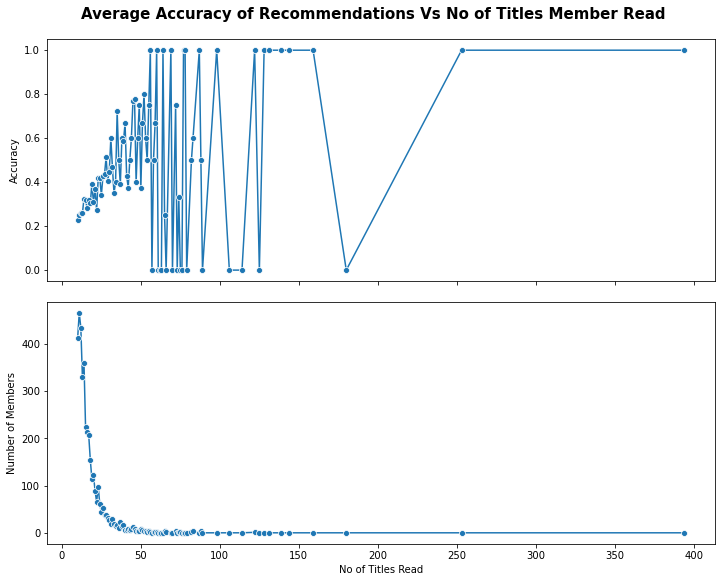

In [521]:
# Calculate the accuracy of the recommendation based on number of mangas read
test_bsm_results_summary = calculate_accuracy_by_manga_numbers_read(test_bsm_result)
plot_accuracy(test_bsm_results_summary)

In [522]:
# Apply grouping based on number of titles read
result = test_bsm_result
result['groupings'] = result['no_titles_read'].apply(lambda x: 'heavy_readers' if x > 50 else 'moderate_reader' if x > 30 else 'light_reader')

# Calculate the mean Accuracy of Each Groups
result.groupby('groupings')['result'].agg(['mean', 'count'])

,mean,count
groupings,,
heavy_readers,0.574713,87
light_reader,0.298441,3592
moderate_reader,0.529880,251


### Item-Based Collaborative Filtering

#### Calculate the titles-based similarity matrix

In [120]:
cf_sm = calculate_titles_based_similarity_matrix(manga, "../data_production/title_cf_sm.csv")

#### Predict the scores of all titles for each users

In [300]:
# Calculate the score of all the members
# Note: Input list of username if you want specific user only
calculate_titles_based_cf_scores(manga, cf_sm, usernames = None)

#### Make Recommendations Based on CF

In [132]:
# Test making recommendation to 1 user
cf_recommend_manga_to_user('wopian')

,title_cf_score,ranking
10104,4.745033,0
191,4.402205,1
3855,4.366495,2
220,4.330109,3
3211,4.326961,4
...,...,...
1,0.813936,2132
5,0.807446,2133
9,0.578737,2134
7,0.373290,2135


#### Calculate which threshold to use when calculating the similarity matrix on the train and test data set

In [235]:
# To decide what threshold to use for calculating the similarity matrix using the train data set based on 10000 members
results_threshold = {}
top_k = 10
member_list = set(data_train['member'].unique()[0:10000]).union(set(data_test['member'].unique()))

for i in range(0, 10, 2):
    count = 0
    thres = i/20
    print(f'Current Threshold: {thres}')
    calculate_titles_based_cf_scores(manga, cf_sm, usernames = list(member_list), threshold=thres)
    print()
    result = evaluate_and_compile(data_train, data_train[data_train['member'].isin(member_list)], 10, 2)
    result_test = evaluate_and_compile(data_train, data_test[data_test['member'].isin(member_list)], 10, 2)
    results_threshold[thres] = [result['result'].sum()/result.shape[0], result['precision@k'].mean(),
                               result_test['result'].sum()/result_test.shape[0], result_test['precision@k'].mean()]
    print()

Current Threshold: 0.0
Completion: 100.0%									
Assessing recommendations. Progress: 100.0%99999999999%%
Complete!!
Assessing recommendations. Progress: 100.0%54707379136%%
Complete!!

Current Threshold: 0.1
Completion: 100.0%									
Assessing recommendations. Progress: 100.0%99999999999%%
Complete!!
Assessing recommendations. Progress: 100.0%54707379136%%
Complete!!

Current Threshold: 0.2
Completion: 100.0%									
Assessing recommendations. Progress: 100.0%99999999999%%
Complete!!
Assessing recommendations. Progress: 100.0%54707379136%%
Complete!!

Current Threshold: 0.3
Completion: 100.0%									
Assessing recommendations. Progress: 100.0%99999999999%%
Complete!!
Assessing recommendations. Progress: 100.0%54707379136%%
Complete!!

Current Threshold: 0.4
Completion: 100.0%									
Assessing recommendations. Progress: 100.0%99999999999%%
Complete!!
Assessing recommendations. Progress: 100.0%54707379136%%
Complete!!



In [236]:
results_threshold_df= pd.DataFrame.from_dict(results_threshold, orient='index')
results_threshold_df.columns = ['Match_top_10', 'precision@10', 'Match_top_10_test', 'precision@10_test']
results_threshold_df

,Match_top_10,precision@10,Match_top_10_test,precision@10_test
0.0,0.5197,0.16218,0.676590,0.121425
0.1,0.3877,0.11691,0.625445,0.102137
0.2,0.1963,0.06543,0.349873,0.057455
0.3,0.1294,0.04193,0.205344,0.032595
0.4,0.0998,0.02930,0.143766,0.023104


Text(0.5, 0, 'CF Threshold')

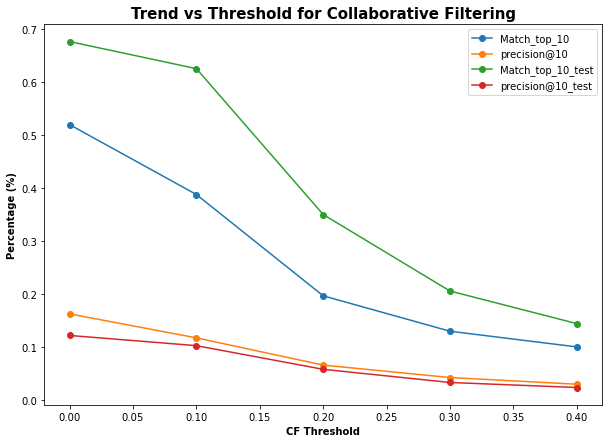

In [248]:
results_threshold_df.plot(figsize=(10,7), marker='o')
plt.title('Percentage vs Threshold for Collaborative Filtering', fontweight = 'bold', fontsize = 15)
plt.ylabel('Percentage (%)', fontweight = 'bold', fontsize=10)
plt.xlabel('CF Threshold', fontweight = 'bold', fontsize=10)

#### Recalculate the similarity matrix using the best threshold

In [285]:
# Since threshold = 0 gives the highest % for "Match_top_10" for 10000 test members, to set threshold = 0 and rerun for all users
# Recalculate cf_scores based on threshold = 0
member_list = set(data_train['member'].unique()[0:10000]).union(set(data_test['member'].unique()))
calculate_titles_based_cf_scores(manga, cf_sm, usernames = list(member_list), threshold=0)

#### Evaluate train data set and determine which area performed well and performed bad

In [473]:
# Evaluate using train data set
train_cfsm_result = evaluate_and_compile(data_train, data_train[data_train['member'].isin(data_train['member'].unique()[0:10000])],
                                         10, 2, drop_train_title_in_recommendation=False)

# Average of the 4 parameters
train_cfsm_result.mean()

Assessing recommendations. Progress: 100.0%																	
Complete!!


result             0.51970
no_titles_read    19.03970
no_match           1.62180
precision@k        0.16218
dtype: float64

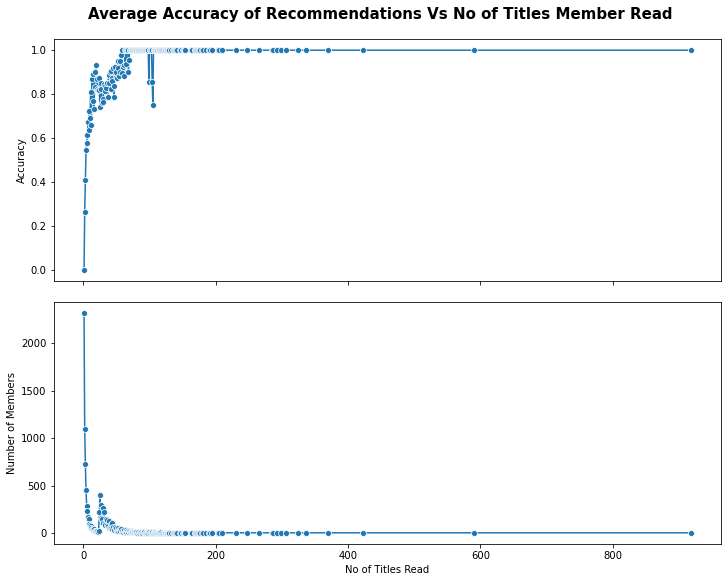

In [474]:
# Calculate the accuracy of the recommendation based on number of mangas read
train_cfsm_results_summary = calculate_accuracy_by_manga_numbers_read(train_cfsm_result)
plot_accuracy(train_cfsm_results_summary)

In [475]:
# Apply grouping based on number of titles read
result = train_cfsm_result
result['groupings'] = result['no_titles_read'].apply(lambda x: 'heavy_readers' if x > 50 else 'moderate_reader' if x > 30 else 'light_reader')

# Calculate the mean Accuracy of Each Groups
result.groupby('groupings')['result'].agg(['mean', 'count'])

,mean,count
groupings,,
heavy_readers,0.961440,778
light_reader,0.401923,7591
moderate_reader,0.857143,1631


#### Evaluate test data set and determine which area performed well and performed bad

In [462]:
# Evaluate using test data set
test_cfsm_result = evaluate_and_compile(data_train, data_test, 10, 2, drop_train_title_in_recommendation=True)

# Average of the 4 parameters
test_cfsm_result.mean()

Assessing recommendations. Progress: 100.0%																	
Complete!!


result             0.766412
no_titles_read    18.211705
no_match           1.719084
precision@k        0.171908
dtype: float64

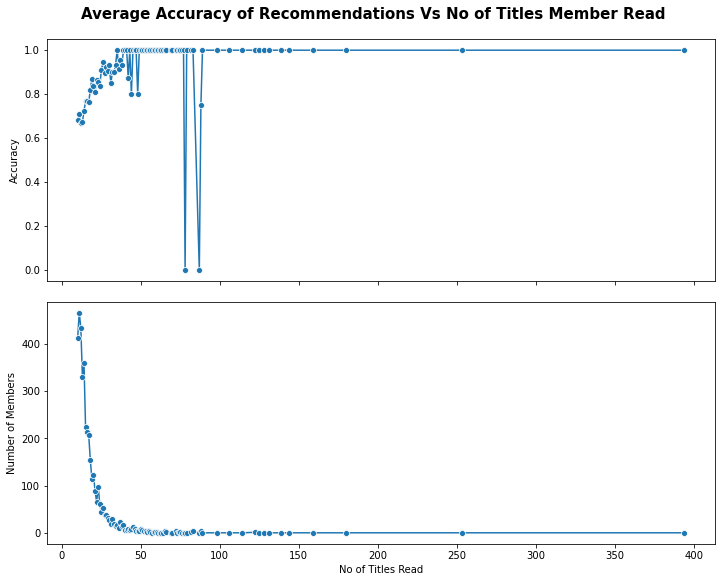

In [463]:
# Calculate the accuracy of the recommendation based on number of mangas read
test_cfsm_results_summary = calculate_accuracy_by_manga_numbers_read(test_cfsm_result)
plot_accuracy(test_cfsm_results_summary)

In [464]:
# Apply grouping based on number of titles read
result = test_cfsm_result
result['groupings'] = result['no_titles_read'].apply(lambda x: 'heavy_readers' if x > 50 else 'moderate_reader' if x > 30 else 'light_reader')

# Calculate the mean Accuracy of Each Groups
result.groupby('groupings')['result'].agg(['mean', 'count'])

,mean,count
groupings,,
heavy_readers,0.965517,87
light_reader,0.749722,3592
moderate_reader,0.936255,251


### Comparing and Evaluating the BSM and CFSM

#### Summary Result

In general, both basic similarity metrics (BSM) and collaborative filtering similarity matrix (CFSM) performed better than the null model.

|Model|Train Accuracy|Test Accuracy|Train Precision@k|Test Precision@k|
|:---:|:---:|:---:|:---:|:---:|
|Null Model|0.015584|0.082798|-|-|
|Basic Similarity Matrix|0.82350|0.319338|0.13937|0.041654|
|Collaborative Filtering Similarity Matrix|0.51970|0.766412|0.16218|0.171908|

#### Accuracy Comparison vs Manga Read Between Models

From the graphs below, we can see that when the member read less than ~10 titles, BSM performed better than CFSM. However, once the mmeber read more than 10 titles, the CFSM performed better with less fluctuations. In addition, it seems that bsm's performance starts degrading as as the number of titles read by member increases as seen from the lower average accuracy and more eratic trend.

Text(0, 0.5, 'Accuracy')

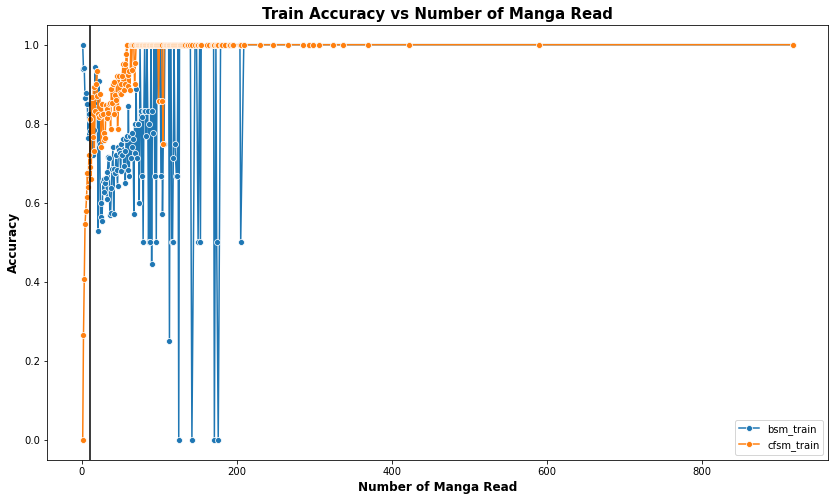

In [525]:
# Plotting the train result for bsm vs cfsm
# CFSM perform better and was more stable than BSM after member reads more than 10 titles
plt.figure(figsize=(14,8), facecolor='white')
sns.lineplot(x='no_titles_read', y='accuracy', data=train_bsm_results_summary, marker='o', label='bsm_train')
sns.lineplot(x='no_titles_read', y='accuracy', data=train_cfsm_results_summary, marker='o', label='cfsm_train')
plt.axvline(10, color='black')
plt.title('Train Accuracy vs Number of Manga Read', fontweight = 'bold', fontsize='15')
plt.xlabel('Number of Manga Read', fontweight = 'bold', fontsize='12')
plt.ylabel('Accuracy', fontweight = 'bold', fontsize='12')

Text(0, 0.5, 'Accuracy')

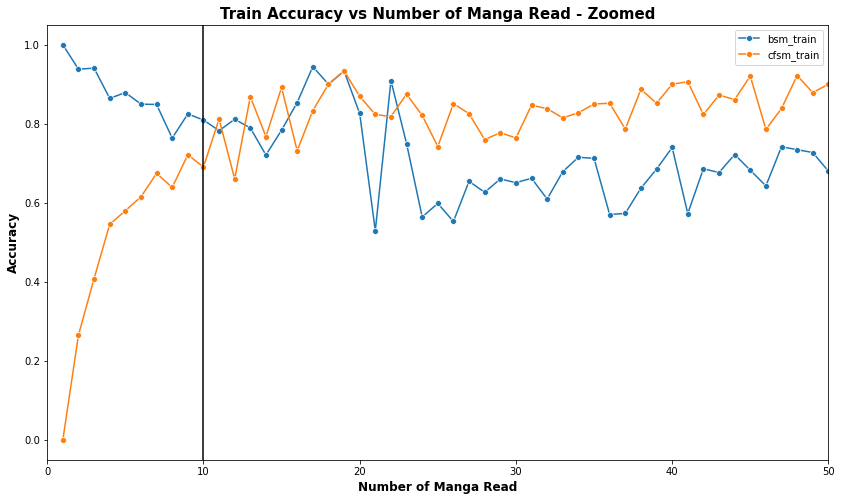

In [524]:
# Plotting the train result for bsm vs cfsm - Zoom to range 0 to 50
plt.figure(figsize=(14,8), facecolor='white')
sns.lineplot(x='no_titles_read', y='accuracy', data=train_bsm_results_summary, marker='o', label='bsm_train')
sns.lineplot(x='no_titles_read', y='accuracy', data=train_cfsm_results_summary, marker='o', label='cfsm_train')
plt.axvline(10, color='black')
plt.xlim(0,50)
plt.title('Train Accuracy vs Number of Manga Read - Zoomed', fontweight = 'bold', fontsize='15')
plt.xlabel('Number of Manga Read', fontweight = 'bold', fontsize='12')
plt.ylabel('Accuracy', fontweight = 'bold', fontsize='12')

Text(0, 0.5, 'Accuracy')

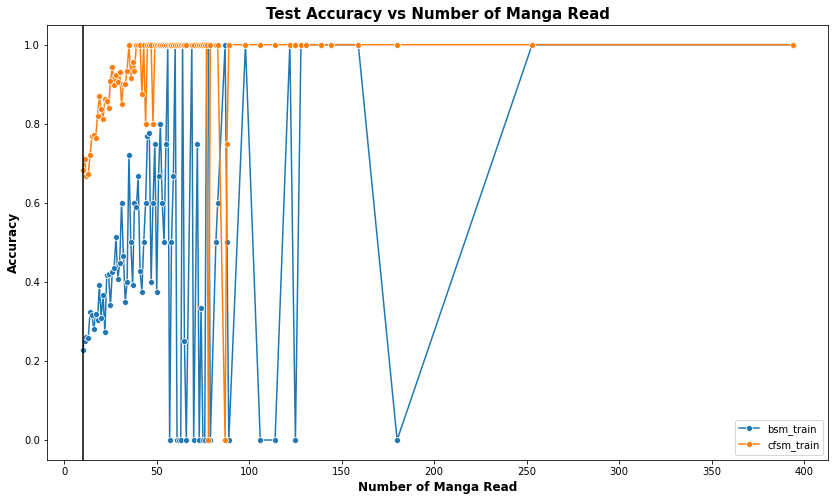

In [523]:
# Plotting the train result for bsm vs cfsm
# CFSM performed better than BSM and was more stable
plt.figure(figsize=(14,8), facecolor='white')
sns.lineplot(x='no_titles_read', y='accuracy', data=test_bsm_results_summary, marker='o', label='bsm_train')
sns.lineplot(x='no_titles_read', y='accuracy', data=test_cfsm_results_summary, marker='o', label='cfsm_train')
plt.axvline(10, color='black')
plt.title('Test Accuracy vs Number of Manga Read', fontweight = 'bold', fontsize='15')
plt.xlabel('Number of Manga Read', fontweight = 'bold', fontsize='12')
plt.ylabel('Accuracy', fontweight = 'bold', fontsize='12')

Text(0, 0.5, 'Accuracy')

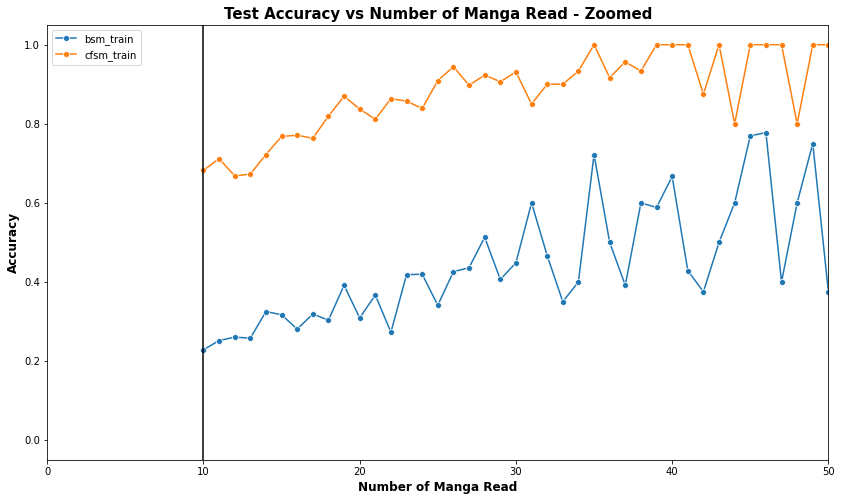

In [526]:
# Plotting the train result for bsm vs cfsm - Zoom to range 0 to 50
plt.figure(figsize=(14,8), facecolor='white')
sns.lineplot(x='no_titles_read', y='accuracy', data=test_bsm_results_summary, marker='o', label='bsm_train')
sns.lineplot(x='no_titles_read', y='accuracy', data=test_cfsm_results_summary, marker='o', label='cfsm_train')
plt.axvline(10, color='black')
plt.xlim(0,50)
plt.title('Test Accuracy vs Number of Manga Read - Zoomed', fontweight = 'bold', fontsize='15')
plt.xlabel('Number of Manga Read', fontweight = 'bold', fontsize='12')
plt.ylabel('Accuracy', fontweight = 'bold', fontsize='12')

#### Results Analysis

The <b>bsm</b> seems to perform poorer for:
<br>
<b>Genres:</b> Romanace

<b>Themes:</b> Not Specified, School

<b>Demographic: </b> Shoujo

<br>

While the <b>cfsm</b> seems to perform poorer for:
<br>
<b>Genres:</b> Adventure, Action, Horror, Fantasy

<b>Themes:</b> Gore, Mythology, Military

<b>Demographic: </b> Seinen, Shounen

In [639]:
# Get the results from train and test for the 2 models
reader_classification = data.groupby('member')['index'].count().sort_values(ascending=False)
reader_classification = reader_classification.reset_index()
reader_classification.columns = ['member', 'titles_count']
reader_classification = reader_classification.merge(train_bsm_result, left_on='member', right_index=True, suffixes=('_main', '_bsm_train'), how='outer')
reader_classification = reader_classification.merge(test_bsm_result, left_on='member', right_index=True, suffixes=('_bsm_train', '_bsm_test'), how='outer')
reader_classification = reader_classification.merge(train_cfsm_result, left_on='member', right_index=True, suffixes=('_bsm_test', '_cfsm_train'), how='outer')
reader_classification = reader_classification.merge(test_cfsm_result, left_on='member', right_index=True, suffixes=('_cfsm_train', '_cfsm_test'), how='outer')

In [641]:
# Extracting list of names of members where the recommendation was not successfuk
bsm_unsuccessful_train_recommendation = reader_classification[reader_classification['result_bsm_train']==False]['member'].values
bsm_successful_train_recommendation = reader_classification[reader_classification['result_bsm_train']==True]['member'].values
bsm_unsuccessful_test_recommendation = reader_classification[reader_classification['result_bsm_test']==False]['member'].values
bsm_successful_test_recommendation = reader_classification[reader_classification['result_bsm_test']==True]['member'].values

cfsm_unsuccessful_train_recommendation = reader_classification[reader_classification['result_cfsm_train']==False]['member'].values
cfsm_successful_train_recommendation = reader_classification[reader_classification['result_cfsm_train']==True]['member'].values
cfsm_unsuccessful_test_recommendation = reader_classification[reader_classification['result_cfsm_test']==False]['member'].values
cfsm_successful_test_recommendation = reader_classification[reader_classification['result_cfsm_test']==True]['member'].values

In [645]:
# Get data from data dataframe for the selected users
bsm_unsuccessful_train_dataset = data_train[data_train['member'].isin(bsm_unsuccessful_train_recommendation)]
bsm_successful_train_dataset = data_train[data_train['member'].isin(bsm_successful_train_recommendation)]
bsm_unsuccessful_test_dataset = data_train[data_train['member'].isin(bsm_unsuccessful_test_recommendation)]
bsm_successful_test_dataset = data_train[data_train['member'].isin(bsm_successful_test_recommendation)]

cfsm_unsuccessful_train_dataset = data_train[data_train['member'].isin(cfsm_unsuccessful_train_recommendation)]
cfsm_successful_train_dataset = data_train[data_train['member'].isin(cfsm_successful_train_recommendation)]
cfsm_unsuccessful_test_dataset = data_train[data_train['member'].isin(cfsm_unsuccessful_test_recommendation)]
cfsm_successful_test_dataset = data_train[data_train['member'].isin(cfsm_successful_test_recommendation)]

In [635]:
# Create genre, themes and demographic list
genres_list = [col for col in data.columns if 'genres' in col]
themes_list = [col for col in data.columns if 'themes' in col]
demographic_list = [col for col in data.columns if 'demographic' in col]

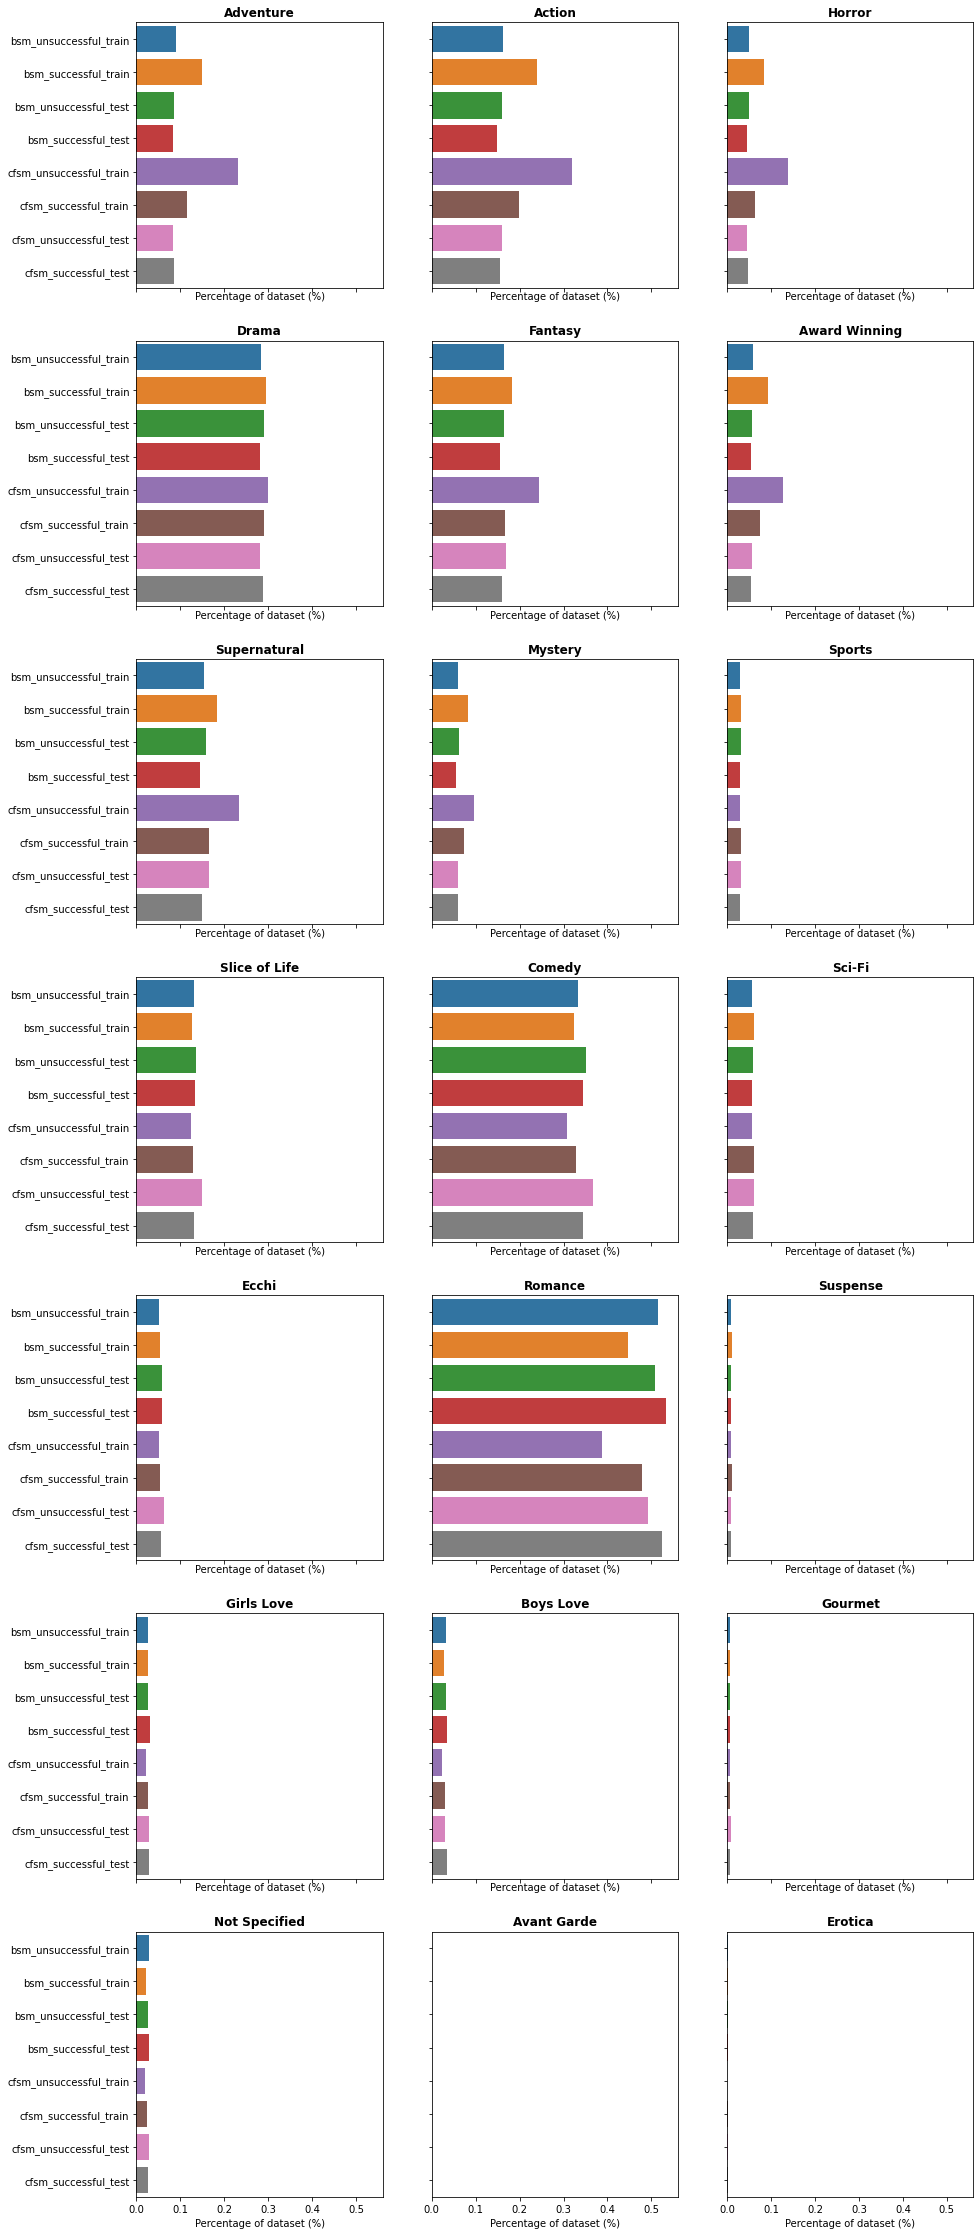

In [693]:
# Create breakdown for genres dataframe for analysis
feature = genres_list
breakdown = pd.DataFrame(bsm_unsuccessful_train_dataset[feature].sum()/bsm_unsuccessful_train_dataset.shape[0])
breakdown = breakdown.merge(pd.DataFrame(bsm_successful_train_dataset[feature].sum()/bsm_successful_train_dataset.shape[0]), left_index=True, right_index=True)
breakdown = breakdown.merge(pd.DataFrame(bsm_unsuccessful_test_dataset[feature].sum()/bsm_unsuccessful_test_dataset.shape[0]), left_index=True, right_index=True)
breakdown = breakdown.merge(pd.DataFrame(bsm_successful_test_dataset[feature].sum()/bsm_successful_test_dataset.shape[0]), left_index=True, right_index=True)

breakdown = breakdown.merge(pd.DataFrame(cfsm_unsuccessful_train_dataset[feature].sum()/cfsm_unsuccessful_train_dataset.shape[0]), left_index=True, right_index=True)
breakdown = breakdown.merge(pd.DataFrame(cfsm_successful_train_dataset[feature].sum()/cfsm_successful_train_dataset.shape[0]), left_index=True, right_index=True)
breakdown = breakdown.merge(pd.DataFrame(cfsm_unsuccessful_test_dataset[feature].sum()/cfsm_unsuccessful_test_dataset.shape[0]), left_index=True, right_index=True)
breakdown = breakdown.merge(pd.DataFrame(cfsm_successful_test_dataset[feature].sum()/cfsm_successful_test_dataset.shape[0]), left_index=True, right_index=True)


breakdown.columns = ['bsm_unsuccessful_train', 'bsm_successful_train', 'bsm_unsuccessful_test', 'bsm_successful_test', 
                           'cfsm_unsuccessful_train', 'cfsm_successful_train', 'cfsm_unsuccessful_test', 'cfsm_successful_test']

# Plot which genres are not showing comparable results among the groups
cols = 3
rows = math.ceil(breakdown.shape[0]/cols)
fig, ax = plt.subplots(rows, cols, figsize=(15,40), facecolor='white', sharey=True, sharex=True)
for i, genre in enumerate(breakdown.index):
    sns.barplot(x=breakdown.loc[genre,:].values, y =breakdown.loc[genre,:].index, ax=ax[int(i/cols), i%cols])
    ax[int(i/cols), i%cols].set_title(genre.replace('genres_', ""), fontweight='bold')
    ax[int(i/cols), i%cols].set_xlabel('Percentage of dataset (%)')

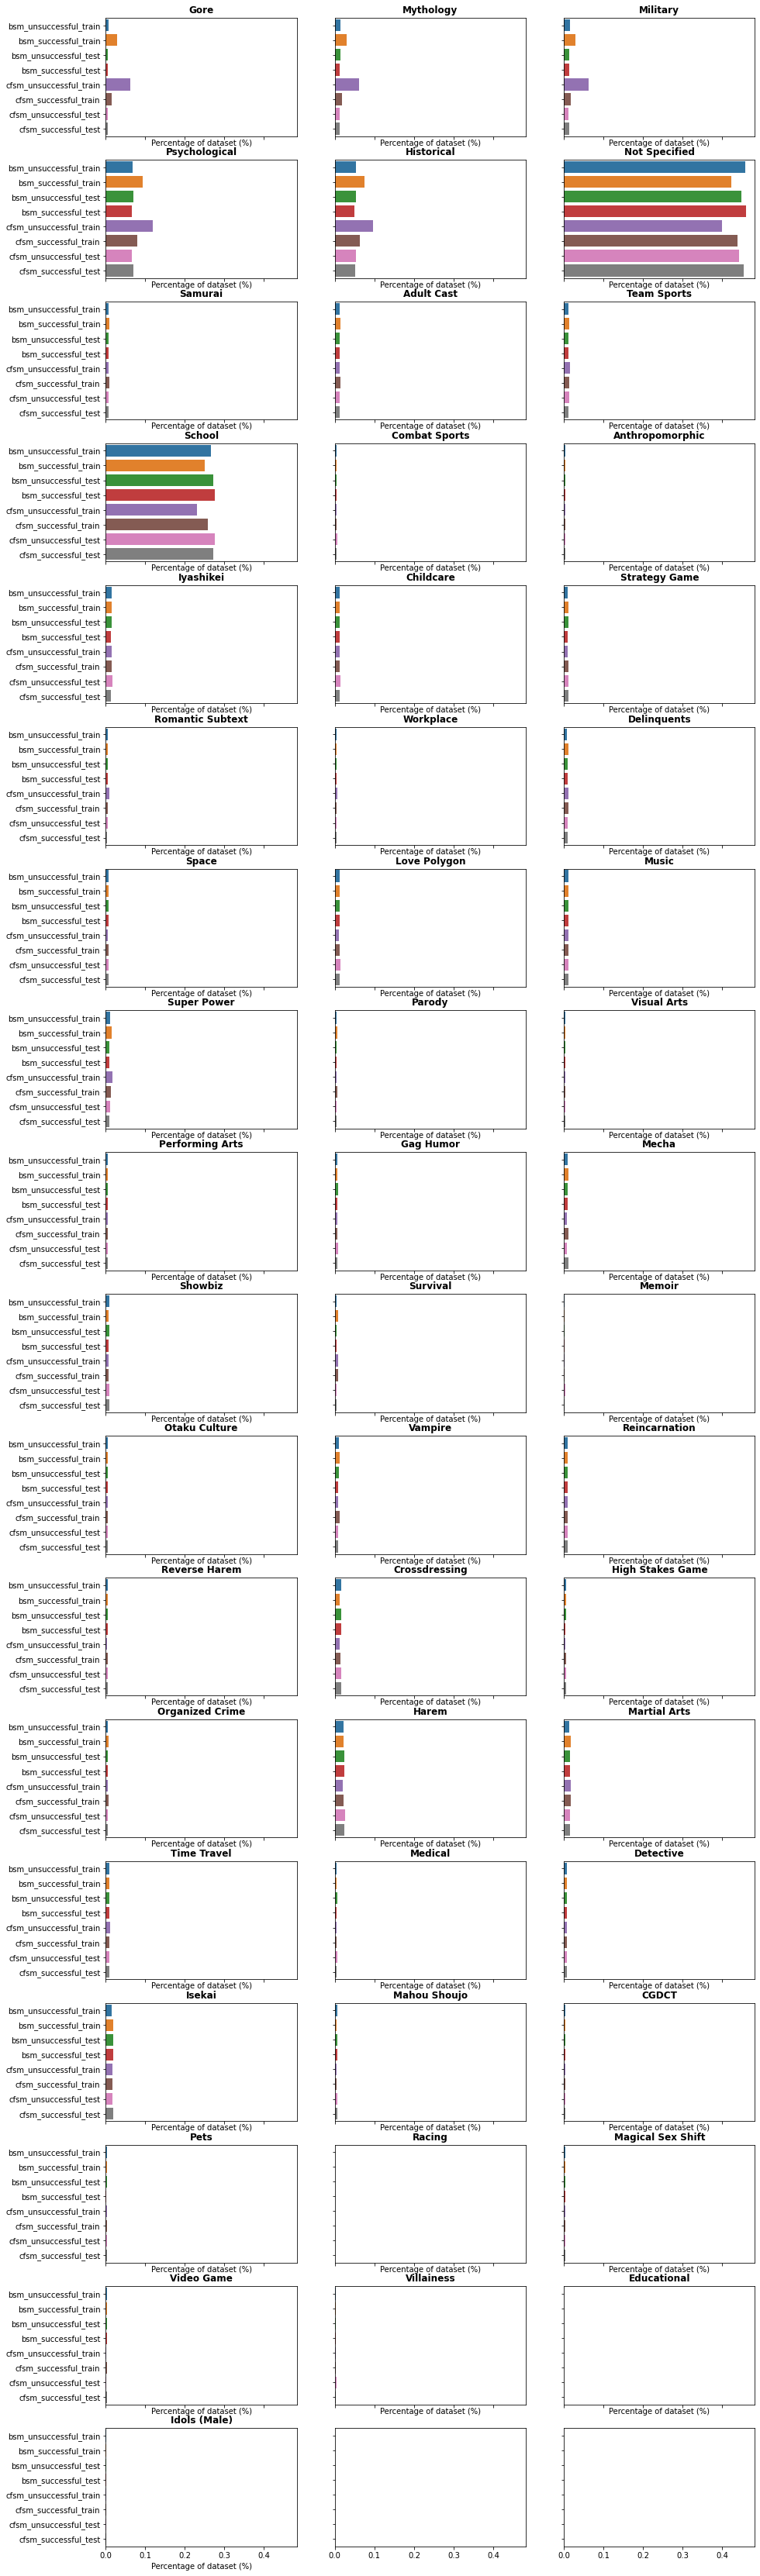

In [696]:
# Create breakdown for themes dataframe for analysis
feature = themes_list
breakdown = pd.DataFrame(bsm_unsuccessful_train_dataset[feature].sum()/bsm_unsuccessful_train_dataset.shape[0])
breakdown = breakdown.merge(pd.DataFrame(bsm_successful_train_dataset[feature].sum()/bsm_successful_train_dataset.shape[0]), left_index=True, right_index=True)
breakdown = breakdown.merge(pd.DataFrame(bsm_unsuccessful_test_dataset[feature].sum()/bsm_unsuccessful_test_dataset.shape[0]), left_index=True, right_index=True)
breakdown = breakdown.merge(pd.DataFrame(bsm_successful_test_dataset[feature].sum()/bsm_successful_test_dataset.shape[0]), left_index=True, right_index=True)

breakdown = breakdown.merge(pd.DataFrame(cfsm_unsuccessful_train_dataset[feature].sum()/cfsm_unsuccessful_train_dataset.shape[0]), left_index=True, right_index=True)
breakdown = breakdown.merge(pd.DataFrame(cfsm_successful_train_dataset[feature].sum()/cfsm_successful_train_dataset.shape[0]), left_index=True, right_index=True)
breakdown = breakdown.merge(pd.DataFrame(cfsm_unsuccessful_test_dataset[feature].sum()/cfsm_unsuccessful_test_dataset.shape[0]), left_index=True, right_index=True)
breakdown = breakdown.merge(pd.DataFrame(cfsm_successful_test_dataset[feature].sum()/cfsm_successful_test_dataset.shape[0]), left_index=True, right_index=True)


breakdown.columns = ['bsm_unsuccessful_train', 'bsm_successful_train', 'bsm_unsuccessful_test', 'bsm_successful_test', 
                           'cfsm_unsuccessful_train', 'cfsm_successful_train', 'cfsm_unsuccessful_test', 'cfsm_successful_test']

# Plot which genres are not showing comparable results among the groups
cols = 3
rows = math.ceil(breakdown.shape[0]/cols)
fig, ax = plt.subplots(rows, cols, figsize=(15,60), facecolor='white', sharey=True, sharex=True)
for i, genre in enumerate(breakdown.index):
    sns.barplot(x=breakdown.loc[genre,:].values, y =breakdown.loc[genre,:].index, ax=ax[int(i/cols), i%cols])
    ax[int(i/cols), i%cols].set_title(genre.replace('themes_', ""), fontweight='bold')
    ax[int(i/cols), i%cols].set_xlabel('Percentage of dataset (%)')

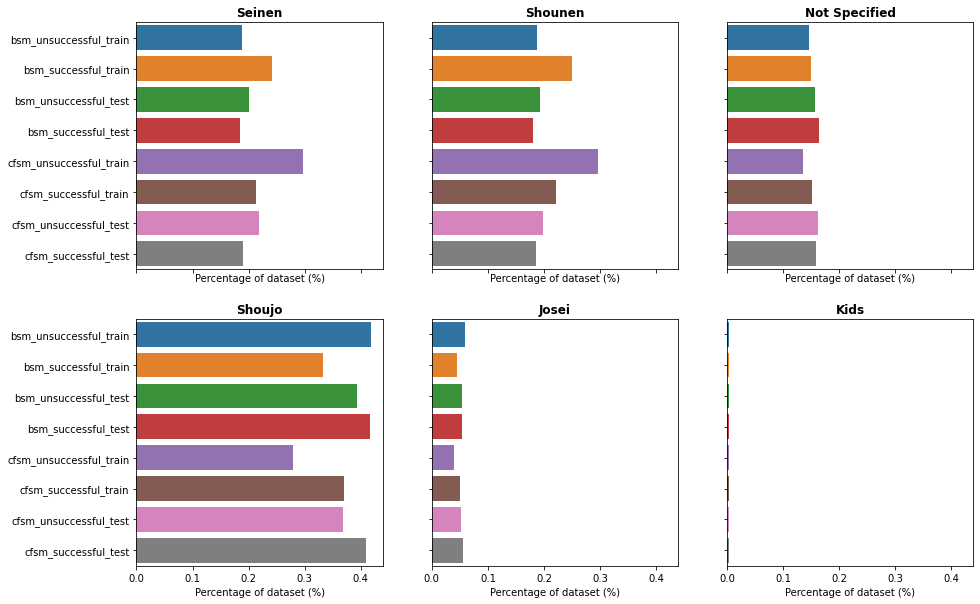

In [697]:
# Create breakdown for demographic dataframe for analysis
feature = demographic_list
breakdown = pd.DataFrame(bsm_unsuccessful_train_dataset[feature].sum()/bsm_unsuccessful_train_dataset.shape[0])
breakdown = breakdown.merge(pd.DataFrame(bsm_successful_train_dataset[feature].sum()/bsm_successful_train_dataset.shape[0]), left_index=True, right_index=True)
breakdown = breakdown.merge(pd.DataFrame(bsm_unsuccessful_test_dataset[feature].sum()/bsm_unsuccessful_test_dataset.shape[0]), left_index=True, right_index=True)
breakdown = breakdown.merge(pd.DataFrame(bsm_successful_test_dataset[feature].sum()/bsm_successful_test_dataset.shape[0]), left_index=True, right_index=True)

breakdown = breakdown.merge(pd.DataFrame(cfsm_unsuccessful_train_dataset[feature].sum()/cfsm_unsuccessful_train_dataset.shape[0]), left_index=True, right_index=True)
breakdown = breakdown.merge(pd.DataFrame(cfsm_successful_train_dataset[feature].sum()/cfsm_successful_train_dataset.shape[0]), left_index=True, right_index=True)
breakdown = breakdown.merge(pd.DataFrame(cfsm_unsuccessful_test_dataset[feature].sum()/cfsm_unsuccessful_test_dataset.shape[0]), left_index=True, right_index=True)
breakdown = breakdown.merge(pd.DataFrame(cfsm_successful_test_dataset[feature].sum()/cfsm_successful_test_dataset.shape[0]), left_index=True, right_index=True)


breakdown.columns = ['bsm_unsuccessful_train', 'bsm_successful_train', 'bsm_unsuccessful_test', 'bsm_successful_test', 
                           'cfsm_unsuccessful_train', 'cfsm_successful_train', 'cfsm_unsuccessful_test', 'cfsm_successful_test']

# Plot which genres are not showing comparable results among the groups
cols = 3
rows = math.ceil(breakdown.shape[0]/cols)
fig, ax = plt.subplots(rows, cols, figsize=(15,10), facecolor='white', sharey=True, sharex=True)
for i, genre in enumerate(breakdown.index):
    sns.barplot(x=breakdown.loc[genre,:].values, y =breakdown.loc[genre,:].index, ax=ax[int(i/cols), i%cols])
    ax[int(i/cols), i%cols].set_title(genre.replace('demographic_', ""), fontweight='bold')
    ax[int(i/cols), i%cols].set_xlabel('Percentage of dataset (%)')

### Conclusion

In conclusion, cfsm performs better than bsm when the number of titles read by the member is high. However it struggles to recommend titles that member likes when the number of titles they read are low. On the otherhand, bsm is much better in recommending titles to members who read less than 10 titles. As such, in order to get the best from the 2 models, it is recommended to have a hybrid model where bsm will recommend titles to member who read less than 10 titles (but at least 1 title) while cfsm will recommend titles to members who read more than 10 titles. For member who has not read any titles yet, the top 10 titles, based on average score, could be recommended as a starting point. In addition from the genres, themes and demographic where the 2 models did not perform as well. Hence, in future enhancement, a weight could be applied to each model so that the recommendation from the model which is more aligned with the member preference would have a higher weightage. 